# Yelp project

## Assignation scores to yelp users

In [0]:
import pandas as pd
#import cPickle as pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pandas.tools.plotting import scatter_matrix
from ast import literal_eval 
from collections import defaultdict
import datetime
import ast

# analysis
import statsmodels.api as sm
from scipy.stats import pearsonr
#from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score 
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import normalize, scale, StandardScaler, Normalizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [0]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive/


In [0]:
users = pd.read_csv('drive/My Drive/yelp/user.csv')
users.head()

,yelping_since,votes,review_count,name,user_id,friends,fans,average_stars,type,compliments,elite
0,2004-10,"{'funny': 167, 'useful': 282, 'cool': 246}",108,Russel,18kPq7GPye-YQ3LyKyAZPw,"['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bx...",69,4.14,user,"{'profile': 8, 'cute': 15, 'funny': 11, 'plain...","[2005, 2006]"
1,2004-10,"{'funny': 8399, 'useful': 15242, 'cool': 12091}",1292,Jeremy,rpOyqD_893cqmDAtJLbdog,"['18kPq7GPye-YQ3LyKyAZPw', '4U9kSBLuBDU391x6bx...",1345,3.67,user,"{'profile': 117, 'cute': 204, 'funny': 594, 'p...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
2,2004-10,"{'funny': 722, 'useful': 1349, 'cool': 657}",395,Michael,4U9kSBLuBDU391x6bxU-YA,"['18kPq7GPye-YQ3LyKyAZPw', 'rpOyqD_893cqmDAtJL...",105,3.68,user,"{'profile': 9, 'cute': 22, 'funny': 96, 'plain...","[2005, 2006, 2007, 2008, 2009, 2010, 2011, 201..."
3,2004-10,"{'funny': 1, 'useful': 11, 'cool': 5}",11,Ken,fHtTaujcyKvXglE33Z5yIw,"['18kPq7GPye-YQ3LyKyAZPw', 'rpOyqD_893cqmDAtJL...",2,4.64,user,{'cute': 2},[]
4,2004-10,"{'funny': 13, 'useful': 37, 'cool': 16}",66,Katherine,SIBCL7HBkrP4llolm4SC2A,"['rpOyqD_893cqmDAtJLbdog', 'HDQixQ-WZEV0LVPJlI...",5,3.80,user,"{'cute': 2, 'plain': 2, 'writer': 2, 'note': 1...",[2005]


In [0]:
users['elite'] = [ast.literal_eval(n) for n in users['elite']]
users['friends'] = [ast.literal_eval(n) for n in users['friends']]
users['votes'] = [ast.literal_eval(n) for n in users['votes']]
users['compliments'] = [ast.literal_eval(n) for n in users['compliments']]

# 2. Parse data and engineer features

Process/engineer user metadata features. 

Features include: 
* elite status
* number of total votes and compliments
* total years elite
* number of friends, elite friends, and % elite friends
* years yelping
* average votes/compliments per review.

In [0]:
# add elite yes/no
users['is_elite'] = users.elite.apply(lambda x: 1 if len(x) > 0 else 0)

In [0]:
# add total votes and compliments
users['votes_num'] = [sum(users['votes'][i].values()) for i in range(len(users['votes']))]
users['comps_num'] = [sum(users['compliments'][i].values()) for i in range(len(users['compliments']))]


In [0]:
# add total elite years
users['elite_yrs'] = users.elite.apply(lambda x: len(x))

# add total friends
users['friends_num'] = users.friends.apply(lambda x: len(x))

In [0]:
# find number of elite friends
eliteusers = users[['user_id', 'is_elite']]
eliteusers.set_index('user_id', inplace = True)
elite_dict = eliteusers.to_dict()['is_elite']

def get_num_elite_friends(flist):
    return sum(map(lambda x: elite_dict[x], flist))

users['elite_friends_num'] = users.friends.apply(get_num_elite_friends)
users['pct_friends_elite'] = users.loc[:,'elite_friends_num'] / users.loc[:,'friends_num']

In [0]:
# add time on yelp
users['yelping_since'] = pd.to_datetime(users.yelping_since)
users['yrs_yelping'] = users.yelping_since.apply(
    lambda x: datetime.datetime.now().year - x.year)

In [0]:
# get average votes and compliments per review
users['votes_avg'] = users.apply(
    lambda row: row.votes_num / row.review_count if row.review_count > 0 else 0, 
    axis = 1) 
users['comps_avg'] = users.apply(
    lambda row: row.comps_num / row.review_count if row.review_count > 0 else 0, 
    axis = 1) 

In [0]:
# add detailed compliments/votes data

# get list of cols
#comps_features = [col for col in users.columns if "compliments" in col]
#votes_features = [col for col in users.columns if "votes." in col]

# fill in na
#users[comps_features] = users[comps_features].fillna(0)
#users[votes_features] = users[votes_features].fillna(0)

Normalize features

In [0]:
# define function to log transform variables
def log_transform(stat):
    if stat > 0:
        return np.log(stat)
    elif stat == 0:
        return np.log(stat + .001)
    else:
        return np.log(1 + stat)

In [0]:
# log transform
users['review_count_log'] = users.review_count.apply(log_transform)
users['friends_num_log'] = users.friends_num.apply(log_transform)
users['votes_log'] = users.votes_num.apply(log_transform)
users['comps_log'] = users.comps_num.apply(log_transform)
users['elite_yrs_log'] = users.elite_yrs.apply(log_transform)
users['fans_log'] = users.fans.apply(log_transform)
users['votes_avg_log'] = users.votes_avg.apply(log_transform)
users['comps_avg_log'] = users.comps_avg.apply(log_transform)
users['elite_friends_log'] = users.elite_friends_num.apply(log_transform)

#for feature in comps_features + votes_features:
#    users[feature + '_log'] = users[feature].apply(log_transform)

In [0]:
users.head()

,yelping_since,votes,review_count,name,user_id,friends,fans,average_stars,type,compliments,...,comps_avg,review_count_log,friends_num_log,votes_log,comps_log,elite_yrs_log,fans_log,votes_avg_log,comps_avg_log,elite_friends_log
0,2004-10-01,"{'funny': 167, 'useful': 282, 'cool': 246}",108,Russel,18kPq7GPye-YQ3LyKyAZPw,"[rpOyqD_893cqmDAtJLbdog, 4U9kSBLuBDU391x6bxU-Y...",69,4.14,user,"{'profile': 8, 'cute': 15, 'funny': 11, 'plain...",...,2.120370,4.682131,5.298317,6.543912,5.433722,0.693147,4.234107,1.861781,0.751591,5.192957
1,2004-10-01,"{'funny': 8399, 'useful': 15242, 'cool': 12091}",1292,Jeremy,rpOyqD_893cqmDAtJLbdog,"[18kPq7GPye-YQ3LyKyAZPw, 4U9kSBLuBDU391x6bxU-Y...",1345,3.67,user,"{'profile': 117, 'cute': 204, 'funny': 594, 'p...",...,4.770898,7.163947,7.569928,10.483802,8.726481,2.484907,7.204149,3.319855,1.562535,7.441320
2,2004-10-01,"{'funny': 722, 'useful': 1349, 'cool': 657}",395,Michael,4U9kSBLuBDU391x6bxU-YA,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",105,3.68,user,"{'profile': 9, 'cute': 22, 'funny': 96, 'plain...",...,1.513924,5.978886,6.045005,7.911324,6.393591,2.397895,4.653960,1.932438,0.414705,5.605802
3,2004-10-01,"{'funny': 1, 'useful': 11, 'cool': 5}",11,Ken,fHtTaujcyKvXglE33Z5yIw,"[18kPq7GPye-YQ3LyKyAZPw, rpOyqD_893cqmDAtJLbdo...",2,4.64,user,{'cute': 2},...,0.181818,2.397895,1.386294,2.833213,0.693147,-6.907755,0.693147,0.435318,-1.704748,1.098612
4,2004-10-01,"{'funny': 13, 'useful': 37, 'cool': 16}",66,Katherine,SIBCL7HBkrP4llolm4SC2A,"[rpOyqD_893cqmDAtJLbdog, HDQixQ-WZEV0LVPJlIGQe...",5,3.80,user,"{'cute': 2, 'plain': 2, 'writer': 2, 'note': 1...",...,0.151515,4.189655,1.386294,4.189655,2.302585,0.000000,1.609438,0.000000,-1.887070,0.000000


In [0]:
print(len(users))

686556


## Explore potential classification models

Test the following models on exhaustive list of features:
* linear classifiers with stochastic gradient descent optimization (logistic regression, linear SVC)
* k nearest neighbors
* random forest classifier
* naive bayes

Define functions to get scores for different models and feature combinations.

In [0]:
def eval_models(features, df, estimators):
    """Get cross-validated accuracy, precision, recall, f1, and auc scores for list of models. 
    Args: 
    features (list) -- list of features
    df (df) -- df 
    estimators (list) -- list of model types
    Returns: 
    (model, accuracy, precision, recall, f1, auc)
    """
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    for est in estimators: 
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[features], df.is_elite, test_size = .25)
        m = est.fit(xtrain, ytrain)
        acc_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10).mean())
        p_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'precision').mean())
        r_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'recall').mean())
        f1_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'f1').mean())
        auc_scores.append(cross_val_score(est, xtrain, ytrain, cv = 10, scoring = 'roc_auc').mean())
        print ('done with %s' %str(est).split('(')[0])
    return zip([str(x).split('(')[0] for x in estimators], acc_scores, p_scores, r_scores, f1_scores, auc_scores)

In [0]:
def eval_models_pl(features, df, estimators):
    """Get cross-validated accuracy, precision, recall, f1, and auc scores for list of models. 
    Scale data before fitting.
    Args: 
    features (list) -- list of features
    df (df) -- df 
    estimators (list) -- list of model types
    Returns: 
    (model, accuracy, precision, recall, f1, auc)
    """
    acc_scores = []
    p_scores = []
    r_scores = []
    f1_scores = []
    auc_scores = []
    for est in estimators: 
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[features], df.is_elite, test_size = .25)
        pipeline = make_pipeline(StandardScaler(), est)
        acc_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5).mean())
        p_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'precision').mean())
        r_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'recall').mean())
        f1_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'f1').mean())
        auc_scores.append(cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'roc_auc').mean())
        print ('done with %s' %str(est).split('(')[0])
    return zip([str(x).split('(')[0] for x in estimators], acc_scores, p_scores, r_scores, f1_scores, auc_scores)

In [0]:
def eval_models_incr(features, df, est):
    """Get accuracy, precision, and recall for incremental feature combinations.
    Args:
    features (list) -- list of features
    df (df) -- df
    est -- estimator to use 
    Returns:
    (features, accuracy, precision, recall)
    """
    feats = []
    acc_scores = []
    p_scores = []
    r_scores = []
    for i in range(0, len(features)):
        feats.append(features[:i+1])
    for feat in feats:
        xtrain, xtest, ytrain, ytest = train_test_split(
            df[feat], df.is_elite, test_size = .25)
        pipeline = make_pipeline(StandardScaler(), est)
        acc = cross_val_score(pipeline, xtrain, ytrain, cv = 5).mean()
        p = cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'precision').mean()
        r = cross_val_score(pipeline, xtrain, ytrain, cv = 5, scoring = 'recall').mean()
        acc_scores.append(acc)
        p_scores.append(p)
        r_scores.append(r)
        print (feat)
        print ('acc:', acc)
        print ('precision:', p)
        print ('recall:', r, '\n')

Define features and split dataset.

In [0]:
users.columns

Index(['yelping_since', 'votes', 'review_count', 'name', 'user_id', 'friends',
       'fans', 'average_stars', 'type', 'compliments', 'elite', 'is_elite',
       'votes_num', 'comps_num', 'elite_yrs', 'friends_num',
       'elite_friends_num', 'pct_friends_elite', 'yrs_yelping', 'votes_avg',
       'comps_avg', 'review_count_log', 'friends_num_log', 'votes_log',
       'comps_log', 'elite_yrs_log', 'fans_log', 'votes_avg_log',
       'comps_avg_log', 'elite_friends_log'],
      dtype='object')

In [0]:
# all features
log_features = ['review_count_log', 'friends_num_log', 'votes_log', 
                'comps_log', 'fans_log', 'elite_friends_log',
                'average_stars']

In [0]:
users_arizona = pd.read_csv('drive/My Drive/yelp/Users_arizona.csv')
users_id = pd.read_csv('drive/My Drive/yelp/Users_id.csv')

#users=users.iloc[0:100000]
#users_arizona
#d = df[~(df['l'].isin(dfc['l'])

#print(len(users_arizona))
#print(len(users))
users_training = users[~(users['user_id'].isin(users_arizona['user_id']))]
print(len(users_training))
#exclude also the new users from the training set
users_training = users_training[~(users_training['user_id'].isin(users_id['User_id']))]
print(len(users_training))

#choose arizona users
users_ariz = users[(users['user_id'].isin(users_arizona['user_id']))]


#new users 
new_users = users[(users['user_id'].isin(users_id['User_id']))]

print(len(users_ariz))
users_training=users_training.iloc[0:300000]
len(users_training)
print(len(new_users))

439528
339921
247028
202015


In [0]:
#Train on users who are not in Arizona
Xtrain = users_training[log_features]

# Test on Arizona users
Xtest = users_ariz[log_features]

ytrain =users_training.is_elite
ytest=users_ariz.is_elite

xtest_2 = new_users[log_features]
ytest_2 = new_users.is_elite

In [0]:
#Xtrain, Xtest, ytrain, ytest = train_test_split(
 #   users_training[log_features], users_training.is_elite, test_size = .25, random_state = 4444)

In [0]:
Xtest

,review_count_log,friends_num_log,votes_log,comps_log,fans_log,elite_friends_log,average_stars
1,7.163947,7.569928,10.483802,8.726481,7.204149,7.441320,3.67
2,5.978886,6.045005,7.911324,6.393591,4.653960,5.605802,3.68
5,7.397562,7.099202,10.793783,9.764915,6.714171,6.877296,4.35
9,0.000000,0.693147,0.000000,0.693147,-6.907755,0.000000,5.00
11,6.891626,4.836282,8.606851,6.825460,4.430817,4.521789,4.01
12,3.871201,2.639057,4.770685,2.079442,2.079442,1.791759,3.83
19,0.000000,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,1.00
20,0.693147,-6.907755,-6.907755,-6.907755,-6.907755,-6.907755,2.50
23,3.091042,-6.907755,2.708050,-6.907755,-6.907755,-6.907755,4.19
28,2.890372,-6.907755,2.197225,-6.907755,-6.907755,-6.907755,4.56


Evaluate potential models using all features and default hyperparameters.

In [0]:
estimators = [LogisticRegression(), 
              SVC(), 
              SGDClassifier(loss = 'log'), 
              SGDClassifier(loss = 'hinge'), 
              GaussianNB(), 
              RandomForestClassifier(), 
              KNeighborsClassifier()]

In [0]:
# without scaling
eval_models(log_features, users, estimators)

# <a id='5'></a> Optimize final classification models

Random forest and SGD classifiers appeared to have the best performance in the previous step. RFC appears to achieve the highest accuracy score, but takes some time to train and run, especially with increasing numbers of trees. SGD classifiers perform not quite as well, but are fast to train and run.

Next, let's define functions to conduct grid search for SGD and RF models to choose a final model.

In [0]:
def grid_search_scores_sgd(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), SGDClassifier())
    param = {
        'sgdclassifier__loss': ['hinge', 'log', 'squared_hinge'],
        'sgdclassifier__penalty': ['l1', 'l2', 'elasticnet', 'none'],
        'sgdclassifier__alpha': 10.0**-np.arange(3,7),
        'sgdclassifier__n_iter': [50]}
    for score in scores: 
        print (score, '\n')
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.best_score_, grid_search.best_params_
    return output      

In [0]:
def grid_search_scores_rf(Xtrain, ytrain):
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    output = defaultdict(list)
    pipeline = make_pipeline(StandardScaler(), RandomForestClassifier())
    param = {
        'randomforestclassifier__max_features': ['auto', 'log2', None],
        'randomforestclassifier__min_samples_leaf': [1, 5, 10, 50, 100, 200, 500]}
    for score in scores: 
        print (score, '\n')
        grid_search = GridSearchCV(pipeline, param_grid = param, verbose = 3, cv = 5, scoring = score)
        grid_search.fit(Xtrain, ytrain)
        output[score] = grid_search.best_score_, grid_search.best_params_
    return output 

In [0]:
sgd_scores = grid_search_scores_sgd(Xtrain, ytrain)
rf_scores = grid_search_scores_rf(Xtrain, ytrain)

accuracy 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9912501458309029, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9920501324977917, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9921166666666666, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9919665327755463, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9926832113868564, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9913334777753704, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9921834636089398, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919833333333333, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919665327755463, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9925165419423657, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9915168080531991, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9922334627756204, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9920833333333333, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9920498674977917, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9924665411090184, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9912834786086898, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.992283461942301, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917166666666667, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9920332005533425, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9924498741645694, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9913334777753704, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9925334577757038, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9918, total=   2.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9921498691644861, total=   2.8s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9924332072201203, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9913501441642639, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9925167913868103, total=   2.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.99205, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919831997199954, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9924332072201203, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9915001416643056, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9923001283311945, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.99195, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9920665344422407, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9924498741645694, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9909168180530324, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9920001333311111, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.99215, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917665294421574, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9926498774979583, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9894835086081899, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9910501491641805, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.99125, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9910331838863982, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9920998683311388, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9899668338861018, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9913668105531575, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9916333333333334, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9912665211086852, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9922498708311805, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9900501658305695, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9916834719421342, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9916666666666667, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9913831897198286, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9924665411090184, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9896501724971251, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9913168113864769, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9912166666666666, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9907165119418657, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9924332072201203, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9900501658305695, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9917334711088148, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9919166666666667, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9918831980533009, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9925665427757129, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919168013866435, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9922167963867269, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9922833333333333, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.99189986499775, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9926332105535092, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9910501491641805, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9925001249979167, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.99245, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9916665277754629, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9925498758312639, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9903001616639723, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9920167997200047, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917833333333334, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9914665244420741, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9925665427757129, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9908334861085648, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9920667988866853, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.99185, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9915331922198704, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9924665411090184, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9916001399976667, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9925334577757038, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9921666666666666, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919665327755463, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9922832047200787, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9911501474975417, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9923667938867685, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9921, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9920332005533425, total=   2.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9926165436090602, total=   2.7s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9909168180530324, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917334711088148, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917833333333334, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917165286088101, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9926332105535092, total=   2.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9907001549974167, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9909168180530324, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9913833333333333, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9907665127752129, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9923998733312221, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9851669138847686, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9889001849969167, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9912666666666666, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9902998383306388, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9913831897198286, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9885001916634722, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9889835169413843, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9886166666666667, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9906165102751713, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9907331788863147, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9895668405526574, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9909834836086066, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9915666666666667, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9906998449974166, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9918331972199537, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9912001466642223, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9912501458309029, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9921, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9913165219420323, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9923332055534259, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9912501458309029, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9912668122197963, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9911166666666666, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.991249854164236, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9913331888864815, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912168130531158, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912334794420093, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9911166666666666, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9918498641644028, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912998549975833, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9921834636089398, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911168147197547, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911666666666666, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9921998699978333, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911665194419907, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9917834702754954, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9922167963867269, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9920666666666667, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9921665361089351, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9923332055534259, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9915834736087732, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.992283461942301, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.99205, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9919831997199954, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9924998749979166, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9915668072198797, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9922167963867269, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9919166666666667, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9919165319421991, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9916165269421157, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9916668055532408, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9921167980533657, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9918, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9919831997199954, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.992366539442324, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9917834702754954, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9696838386026899, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9916333333333334, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9903665061084351, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9924165402756713, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9914001433309445, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9911501474975417, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9914333333333334, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9915831930532175, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9904498408306806, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9911334811086482, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9914334761087316, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912333333333333, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9883831397189953, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9917831963866064, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9915001416643056, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911334811086482, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9917666666666667, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9913831897198286, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9922498708311805, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9761837302711621, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9908501524974583, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9911166666666666, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9910331838863982, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9912665211086852, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9915501408309861, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9920667988866853, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9918833333333333, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9915498591643194, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9922332038867314, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9916834719421342, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9915168080531991, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9910666666666667, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9911165186086435, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9908165136085602, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9891835136081065, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9921334644422592, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9919331988866481, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.985399756662611, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.991383476942051, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.992283461942301, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9896666666666667, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9918665311088518, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9924498741645694, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9904668255529074, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9916334727754538, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.99195, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9893664894414906, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9910498508308472, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9914668088865186, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9919834669422176, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912166666666666, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9913665227753796, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9918498641644028, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9909168180530324, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9866668888851853, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9907833333333333, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9912165202753379, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9913331888864815, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.950750820819653, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9911668138864352, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9911, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9453990899848331, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9911165186086435, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9899168347194214, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9916168063865602, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9906, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9911665194419907, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9911165186086435, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9879668672188797, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9917668038866019, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.99165, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9856664277737962, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9912165202753379, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.984666922217963, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9777670372160464, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9903333333333333, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9911165186086435, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9904331738862314, total=   1.0s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.5min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


precision 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.498, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.610738255033557, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5901162790697675, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5913621262458472, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6737588652482269, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4935064935064935, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6321428571428571, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5792682926829268, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5841584158415841, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6705882352941176, total=   1.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4967741935483871, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6156462585034014, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5960912052117264, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5674846625766872, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7345679012345679, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4929328621908127, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5757575757575758, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5555555555555556, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5612535612535613, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.627906976744186, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.49173553719008267, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.672, total=   2.9s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6066666666666667, total=   2.8s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5886075949367089, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6606498194945848, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5173267326732673, total=   2.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.66015625, total=   2.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6089965397923875, total=   2.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6171171171171171, total=   2.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7064676616915423, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5457142857142857, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6666666666666666, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5921052631578947, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6072874493927125, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6402877697841727, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4863883847549909, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5555555555555556, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5552763819095478, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5741935483870968, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6523297491039427, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.43215339233038347, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5159914712153518, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5124481327800829, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5045045045045045, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.568445475638051, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4311377245508982, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.544392523364486, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5361990950226244, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5093457943925234, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5989717223650386, total=   1.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4396135265700483, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.508298755186722, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5115384615384615, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.513189448441247, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6005154639175257, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.43517138599105815, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4968684759916493, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5021008403361344, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4910313901345291, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5787139689578714, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.48056537102473496, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5344036697247706, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5826086956521739, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.583596214511041, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6333333333333333, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5714285714285714, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7435897435897436, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7012987012987013, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7622377622377622, total=   1.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7619047619047619, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.531317494600432, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.8282828282828283, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5833333333333334, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6532258064516129, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7415730337078652, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.48, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5753424657534246, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5476190476190477, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5400516795865633, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.622478386167147, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4748700173310225, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6334519572953736, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5558252427184466, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5617977528089888, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.64576802507837, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5163398692810458, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6707317073170732, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6454545454545455, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.615686274509804, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.675, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5445544554455446, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6203389830508474, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5914634146341463, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5833333333333334, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7005347593582888, total=   2.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5124481327800829, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5180180180180181, total=   1.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5208791208791209, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5192307692307693, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6212121212121212, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.430635838150289, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5044642857142857, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5231788079470199, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5190156599552572, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5668934240362812, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3932291666666667, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.37225274725274726, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4062968515742129, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4875283446712018, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5568445475638051, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4385432473444613, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4525939177101968, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.49044585987261147, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5059101654846335, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5134615384615384, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.44049459041731065, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4906832298136646, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.501002004008016, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.49798387096774194, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5536480686695279, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6125461254612546, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.8333333333333334, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6523809523809524, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=1.0, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9444444444444444, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7547169811320755, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.8378378378378378, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.75, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.875, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=1.0, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6111111111111112, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.873015873015873, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.8333333333333334, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7204968944099379, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=1.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5425, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.8571428571428571, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.8888888888888888, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5037735849056604, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9230769230769231, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5518394648829431, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7666666666666667, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5637393767705382, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6194331983805668, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6498194945848376, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5914634146341463, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6412213740458015, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6502732240437158, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5853658536585366, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6904761904761905, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5421348314606742, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7215189873417721, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6122448979591837, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.703125, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.711340206185567, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4942528735632184, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6328125, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6612903225806451, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6413043478260869, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6914893617021277, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7692307692307693, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5714285714285714, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5415472779369628, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6966292134831461, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5411764705882353, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=1.0, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4657258064516129, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5459459459459459, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.33066453162530024, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4151436031331593, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5643044619422573, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5703971119133574, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.851063829787234, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=1.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5251396648044693, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6835443037974683, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4645308924485126, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=1.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6171875, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.37891077636152953, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.75, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7338709677419355, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7352941176470589, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.35135135135135137, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.7849462365591398, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6190476190476191, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 
[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5714285714285714, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5064935064935064, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.875, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7857142857142857, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4119897959183674, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.88, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3879003558718861, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6349206349206349, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5433255269320844, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6168831168831169, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.515625, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3184257602862254, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.2905982905982906, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6776315789473685, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7333333333333333, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9166666666666666, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5880149812734082, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.8095238095238095, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.75, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.44773790951638065, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6823529411764706, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6666666666666666, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.27959331880900506, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.46166666666666667, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4267605633802817, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5694050991501416, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5210084033613446, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.8311688311688312, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.7037037037037037, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.484984984984985, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.6451612903225806, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45955882352941174, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5769230769230769, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6521739130434783, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.16186012977649603, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.75, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3333333333333333, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.32, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.21558441558441557, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.502092050209205, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5058823529411764, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 
[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.34823091247672255, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6666666666666666, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.18286151491966335, total=   1.0s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


recall 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4700374531835206, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.33146067415730335, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3801498127340824, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.37335834896810505, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3902439024390244, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.41385767790262173, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3389513108614232, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3389513108614232, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3339587242026266, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3602251407129456, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.42696629213483145, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.34269662921348315, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.35767790262172283, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3302063789868668, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3320825515947467, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4812734082397004, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.41385767790262173, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.40074906367041196, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3677298311444653, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.40150093808630394, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45131086142322097, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3707865168539326, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3782771535580524, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3076923076923077, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.2607879924953096, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.36329588014981273, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.31835205992509363, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.29775280898876405, total=   2.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.30393996247654786, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2926829268292683, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3707865168539326, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.301498127340824, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.33707865168539325, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3151969981238274, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.30956848030018763, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.49625468164794007, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3539325842696629, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3970037453183521, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3602251407129456, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.39587242026266417, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.552434456928839, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4438202247191011, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46441947565543074, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.399624765478424, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4652908067542214, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5224719101123596, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4419475655430712, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4307116104868914, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4071294559099437, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4634146341463415, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5674157303370787, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.43258426966292135, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4250936329588015, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.40337711069418386, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.43151969981238275, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5580524344569289, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4400749063670412, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4419475655430712, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4202626641651032, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4540337711069418, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5187265917602997, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.34831460674157305, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.34831460674157305, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3808630393996248, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4277673545966229, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3707865168539326, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3295880149812734, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2303370786516854, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.1275797373358349, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.26454033771106944, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3146067415730337, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3389513108614232, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3352059925093633, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.300187617260788, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0450281425891182, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5131086142322098, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.40262172284644193, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.38764044943820225, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.39587242026266417, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.43902439024390244, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4044943820224719, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4157303370786517, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3883677298311445, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4352720450281426, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.32397003745318353, total=   2.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.23220973782771537, total=   2.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.29775280898876405, total=   2.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.23827392120075047, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.28330206378986866, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3707865168539326, total=   2.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.38202247191011235, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.33707865168539325, total=   2.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.300187617260788, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.24765478424015008, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5187265917602997, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.42696629213483145, total=   1.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4400749063670412, total=   1.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.40150093808630394, total=   1.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.44652908067542213, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5262172284644194, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45880149812734083, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45692883895131087, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4277673545966229, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45778611632270166, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.49625468164794007, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5374531835205992, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5037453183520599, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.41088180112570355, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.47654784240150094, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5692883895131086, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5224719101123596, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4438202247191011, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.42964352720450283, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5290806754221389, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5430711610486891, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.449438202247191, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4232209737827715, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4052532833020638, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46716697936210133, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.009363295880149813, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0018726591760299626, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.003745318352059925, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.1350844277673546, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.22138836772983114, total=   1.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.19850187265917604, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.09363295880149813, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.00749063670411985, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2607879924953096, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.009380863039399626, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.04307116104868914, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0149812734082397, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.016853932584269662, total=   1.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.009380863039399626, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.028142589118198873, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.09925093632958802, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.035580524344569285, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.056179775280898875, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.14634146341463414, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.150093808630394, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4307116104868914, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.2397003745318352, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.15355805243445692, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.16885553470919323, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3433395872420263, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.250936329588015, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.21161048689138576, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.23782771535580524, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3227016885553471, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3133208255159475, total=   2.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.19101123595505617, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4232209737827715, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.21348314606741572, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.11069418386491557, total=   2.8s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.27392120075046905, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2808988764044944, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.301498127340824, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3333333333333333, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.15196998123827393, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.1951219512195122, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0056179775280898875, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.020599250936329586, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.34831460674157305, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7542213883677298, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.09363295880149813, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2902621722846442, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6666666666666666, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.09380863039399624, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.1125703564727955, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.013108614232209739, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.003745318352059925, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.020599250936329586, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4915572232645403, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.31273408239700373, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6835205992509363, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.26217228464419473, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.1651031894934334, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0150093808630394, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.02247191011235955, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3651685393258427, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.028089887640449437, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.15572232645403378, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46153846153846156, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6329588014981273, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.009363295880149813, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.704119850187266, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3771106941838649, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.23452157598499063, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4288389513108614, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5168539325842697, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.6704119850187266, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.01125703564727955, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0675422138836773, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.7565543071161048, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4400749063670412, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.27340823970037453, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.20637898686679174, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4521575984990619, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.2696629213483146, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.398876404494382, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.04119850187265917, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.1050656660412758, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.075046904315197, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.45131086142322097, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4044943820224719, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.29213483146067415, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.0225140712945591, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.6472795497185742, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.14794007490636704, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0149812734082397, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5074906367041199, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.27392120075046905, total=   2.7s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.11632270168855535, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.40074906367041196, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.6722846441947565, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.398876404494382, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.16885553470919323, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0375234521575985, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.16292134831460675, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.24344569288389514, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.7602996254681648, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3883677298311445, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.1726078799249531, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.49250936329588013, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.16292134831460675, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.38202247191011235, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.14634146341463414, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.013133208255159476, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.8108614232209738, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0149812734082397, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.7940074906367042, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.21575984990619138, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2546816479400749, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.13295880149812733, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.03932584269662921, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.039399624765478425, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.7673545966228893, total=   1.0s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


f1 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.479923518164436, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4413793103448275, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4721603563474388, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4392523364485981, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4645476772616137, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4581976112920738, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4439197166469894, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.43971631205673756, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.41927710843373495, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.45858343337334934, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.46091370558375633, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.44705882352941173, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4326923076923077, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.42807017543859655, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.435, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.500459981600736, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4668141592920354, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.47195767195767196, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4513966480446927, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4988713318284424, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4577397910731244, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46101694915254243, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4485981308411215, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.44649021864211735, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46848989298454224, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.44078947368421045, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.42875157629255994, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.42891566265060244, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.385297845373891, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3217391304347826, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.45444801714898175, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.40106951871657753, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.43529411764705883, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4193939393939394, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.42370744010088274, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.47224835371589835, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46864686468646866, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.48744769874476984, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.43498273878020716, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.509933774834437, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4904722452361226, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46138807429130013, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5039370078740157, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45123152709359604, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5037037037037037, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.472632493483927, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.48938321536905965, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.496031746031746, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.44561774023231254, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.512273212379936, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4719298245614035, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4860968074150361, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.48459958932238195, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4477296726504752, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.512273212379936, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46557377049180326, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46878001921229584, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.48862512363996047, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4523809523809524, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5351521511017838, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4956268221574344, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4781704781704782, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4821052631578948, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4543429844097996, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5125408942202835, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4924623115577889, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4627720504009163, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.34366197183098596, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2940275650842266, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2760736196319018, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.494902687673772, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.44736842105263164, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.46578366445916114, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3042168674698795, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.17880794701986755, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.49107142857142855, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46673936750272627, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.46542261251372113, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.45161290322580644, total=   0.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5131004366812226, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.49466537342386036, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4746835443037974, total=   2.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4964394710071211, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4514721919302072, total=   2.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.47900113507377984, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.44590163934426236, total=   2.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4064171122994652, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.35006784260515605, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3429355281207133, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3983739837398374, total=   2.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4410480349344978, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.45794392523364486, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.41089108910891087, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3850129198966408, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3951285520974289, total=   2.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4906333630686886, total=   2.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.469408224674022, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.47568710359408034, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.44690265486725667, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5044642857142857, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.49387040280210154, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.47173489278752434, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.46926229508196726, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4551863041289024, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.49893842887473455, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.45714285714285713, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4678811121764142, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.44629629629629625, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.43040473840078974, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5091965150048402, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.487510766580534, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.46821392532795153, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4681274900398406, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.44171779141104295, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5201970443349754, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.48235294117647054, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.47248576850094876, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.47817836812144215, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4625850340136054, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.516597510373444, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.10763888888888888, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.022181146025878003, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.14089347079037803, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 
[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2869822485207101, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2247191011235955, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.13402061855670103, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.05100182149362478, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.15692821368948245, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.15050167224080266, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.40897097625329815, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.02578268876611418, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4695837780149413, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.025878003696857672, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.17675941080196397, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0037383177570093464, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.04029304029304029, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.01858736059479554, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0037453183520599247, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.45435684647302904, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.40263157894736845, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.36, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3141654978962132, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.3275862068965517, total=   2.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.40476190476190477, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.46756152125279643, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.423728813559322, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3356643356643356, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5123966942148761, total=   2.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.41849710982658955, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.27522935779816515, total=   2.7s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.35470668485675305, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.39702233250620356, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.37138927097661617, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4205714285714286, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.35783633841886264, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3027656477438137, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3604806408544726, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.4329113924050632, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.43838862559241704, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.13969335604770017, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.49144008056394767, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0979020979020979, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.02592592592592593, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4476854787571338, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.3170466883821933, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.35500000000000004, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.24270353302611367, total=   1.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.12265758091993186, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.11262798634812286, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.24648985959438377, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3882063882063882, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.1312607944732297, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.05444646098003629, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.3790226460071514, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.1708542713567839, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.39454094292803965, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.01486988847583643, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.5355191256830601, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4235294117647059, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.30016528925619834, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.16835016835016836, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.36141304347826086, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5390428211586902, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4509990485252141, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4900900900900901, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.37415881561238223, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 
[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.11262798634812288, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.0037383177570093464, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.14482758620689656, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.332378223495702, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.26127527216174184, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.3579201934703748, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 
[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2146341463414634, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.0074487895716946004, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2247557003257329, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.18739903069466884, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.11015490533562823, total=   2.7s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.4707740916271722, total=   2.8s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.15436241610738258, total=   2.8s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.48648648648648646, total=   2.8s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.5428329092451231, total=   2.7s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4653665097511769, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2218700475435816, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.49949031600407745, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4786610878661088, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2636363636363636, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.025594149908592323, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4883011190233978, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.018484288354898334, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.43488108720271795, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.5400696864111499, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.44580777096114516, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2725880551301685, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.34309623430962344, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.06463195691202873, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.18446601941747573, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.36241007194244607, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.09345794392523363, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.18270799347471453, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.1540983606557377, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.0037453183520599247, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.022058823529411763, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.2297650130548303, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.4723320158102767, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.0, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 
[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.5359223300970873, total=   1.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.04332129963898917, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.4368994234465086, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.28249258160237384, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.42189281641961235, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.40296554731792417, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.21580547112462006, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.2835595776772248, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.12836970474967907, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.339572192513369, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.00746268656716418, total=   1.0s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.7min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


roc_auc 

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9816513284773369, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.4s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9789759391306885, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.8s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9801510440422885, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9774173540381819, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9852627566076039, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9838767153078765, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9804405099507869, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9825371524420022, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.978713773345754, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.986671652882638, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9837906511457681, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9803984068462356, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9824460482312557, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9781170932872294, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9867493298234209, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9818972395793872, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9793778553037535, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9800579716278877, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9755659326732118, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.98584667455299, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9823543590002299, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9799265497642637, total=   2.7s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9815797552020724, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9771041537980711, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9857452875305668, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9841734209556566, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9815580529383086, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.983906581307721, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9795693555066609, total=   2.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9877072297418255, total=   2.2s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9844254097683862, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9815739557564076, total=   2.6s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9831510745258267, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9793567062049235, total=   2.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.987240568640639, total=   2.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9824298422774247, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9794595422545435, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9814484681455213, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9770523008118093, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9849166651364751, total=   2.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9808890324026374, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9782135800745311, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9786876924981901, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9757508492247671, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9824104637591007, total=   1.3s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9838516801783938, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9805488695489626, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9825712889661811, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.978432912205685, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9866091832064598, total=   1.1s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9836355278151625, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9804357233599927, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9824483470931238, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9786724423983837, total=   1.5s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9863606296160912, total=   1.4s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9801930872937491, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9767552759094853, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9797242587619073, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9755131489518756, total=   1.0s
[CV] sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9844943638154435, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9818003426065343, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9789393469036962, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9805492510056104, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9760410177155799, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9854838456256934, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9827142350502016, total=   1.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9798977672380408, total=   1.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9815129937341214, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9770551403425446, total=   1.1s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9859086078733625, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9827333184319204, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9793970961391171, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9811063156222717, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9772223887028575, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9857749606267514, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9818039640403587, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9785335258802461, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.979946240642845, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9758519049686045, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9842059621437549, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9821935988291495, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9788843640910211, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9808887267718902, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9768434217758817, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9852921142003733, total=   2.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9846200224730437, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9824375260152785, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9819078626240456, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9805171277654425, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9881134719390317, total=   2.2s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.984017321412455, total=   2.7s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9814161872045736, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9830504599550229, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.978756460957809, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9879552154260474, total=   2.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9814144237237548, total=   1.9s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9790643336067358, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.981538155249637, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9763899013919316, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.984643817783148, total=   2.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.980971160223632, total=   1.5s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9781469456921597, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9789979758678706, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9752288488245826, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.983642567695517, total=   1.3s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9796096900499814, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9788339474340378, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9766874622341083, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9754692624268435, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9837227055629373, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9760763672849367, total=   1.6s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9773940338546749, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9794860903741174, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9746954903014566, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9787672511746035, total=   1.4s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9810285363317043, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9777275836552788, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.979588310999103, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9756955414761105, total=   1.0s
[CV] sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=0.0001, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9837662765845544, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9834798376514367, total=   1.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.97986344234353, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9812290685477781, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9782171867456511, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9859991258031376, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9833026708105947, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9797787952642226, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9801354086324594, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9786227506105148, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9854895246871642, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9826748086576076, total=   1.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9795687363570353, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9823689576305272, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9780551441916863, total=   1.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9872582052815398, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9761197300186444, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9803511392621432, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9823236417095924, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9775315504992557, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9856308386667609, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9850234187103678, total=   2.7s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9829303874134327, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9843394286553573, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9811506270725026, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9885169061558441, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9851152141851375, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.983022655249136, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9841811535902996, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9814786244227787, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9885323027224979, total=   2.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9851532234949305, total=   2.7s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9819914598402828, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9845169448793387, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9814375458781404, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9884843146530702, total=   2.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9852037661148294, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9829812134498919, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9843061738864156, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9813094514916341, total=   2.1s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9885341326423052, total=   2.2s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9840150540799735, total=   1.5s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9816546664946013, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9817418092181464, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9823708049798301, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9875915030891886, total=   1.3s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9841763181027163, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.982994974898425, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9809940177945764, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9814095922755677, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9871367995674322, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.984797756147006, total=   1.6s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9835902756377202, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9823811132562957, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9810821628314388, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9883491845404084, total=   1.4s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9848924802595642, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9831319595691791, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9838538649410467, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.976853060405211, total=   1.0s
[CV] sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-05, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9878142169498656, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9826652354760191, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9793578272001675, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9811484036892135, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.97937697729934, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9837998461479147, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9803069892602128, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9772467202248388, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9829301948389354, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.972078231721988, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9863237788172143, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9822567849767052, total=   1.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9700076314632438, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9788518721742107, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9782254529351251, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9845333915878839, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9827971501394189, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.980454334380778, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9797915870725109, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9718105901750091, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9844957520304696, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9851510821253646, total=   2.7s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9796499666922561, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9833959190604116, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9781459145241933, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9876515749394124, total=   2.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9844300389055359, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9817598140384284, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9826623301944106, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9808651280322322, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9882934666373122, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9816306390684437, total=   2.8s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9809983997041383, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9839281213285129, total=   2.7s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9811787384267825, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9883191801656381, total=   2.6s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9837148214705553, total=   2.2s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9823941317908418, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9842299965321826, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9803552114128438, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=log, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9883795359689354, total=   2.1s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9838962080690711, total=   1.5s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9572669863983354, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.9767316759609966, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.97615093910538, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l1, score=0.947591222922156, total=   1.3s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9817252687088152, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9836490688285933, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9793141481028846, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9779863486720366, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=l2, score=0.9790371012454876, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.980734916775357, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9550417570214406, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9355487937525374, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9831882743282002, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=elasticnet, score=0.9872096808563066, total=   1.4s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9834138015929145, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9749055419841012, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9802155853765178, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9717781879742845, total=   1.0s
[CV] sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none 


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


[CV]  sgdclassifier__alpha=1e-06, sgdclassifier__loss=squared_hinge, sgdclassifier__n_iter=50, sgdclassifier__penalty=none, score=0.9674820726227024, total=   1.0s


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  6.8min finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.9918001366643889, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.9920334661088982, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.9924833333333334, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.9923832063867731, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.9927165452757546, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.9922501291645139, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.9926001233312778, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.9924833333333334, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.9926998783313056, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.9927498791646527, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.9927667872202129, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.9926834552757454, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.9924, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.9925665427757129, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.993049884164736, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.9925667905534907, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.9926667888868519, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.9924833333333334, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.9926165436090602, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.9925165419423657, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.9924834586090232, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.9925501241645972, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.9925666666666667, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.9925165419423657, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.9925665427757129, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.992350127497875, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.9923001283311945, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.99195, total=   1.7s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.9921998699978333, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.9923332055534259, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500, score=0.9920167997200047, total=   1.6s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500, score=0.9917668038866019, total=   1.7s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500, score=0.992, total=   1.7s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500, score=0.9917165286088101, total=   1.7s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=500, score=0.9920665344422407, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1, score=0.9921834636089398, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1, score=0.9922001299978334, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1, score=0.9922333333333333, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1, score=0.9922998716645277, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=1, score=0.9927832130535509, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5, score=0.9925001249979167, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5, score=0.992800119998, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5, score=0.99265, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5, score=0.9928832147202453, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=5, score=0.992816546942449, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10, score=0.9924167930534491, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10, score=0.9926834552757454, total=   2.0s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10, score=0.9927, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10, score=0.992599876664611, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=10, score=0.9928498808313472, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50, score=0.9925167913868103, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50, score=0.9925001249979167, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50, score=0.9925833333333334, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50, score=0.9923998733312221, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=50, score=0.9926665444424074, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100, score=0.9925001249979167, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100, score=0.9925334577757038, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100, score=0.9925833333333334, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100, score=0.9923998733312221, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=100, score=0.9927498791646527, total=   1.9s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200, score=0.9925834569423843, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200, score=0.9925501241645972, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200, score=0.9924166666666666, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200, score=0.9923332055534259, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=200, score=0.9924498741645694, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500, score=0.9920834652755788, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500, score=0.9917834702754954, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500, score=0.9919833333333333, total=   1.8s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500, score=0.99189986499775, total=   1.7s
[CV] randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=log2, randomforestclassifier__min_samples_leaf=500, score=0.9920665344422407, total=   1.7s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1, score=0.9918834686088566, total=   4.4s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1, score=0.9922001299978334, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1, score=0.9922333333333333, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1, score=0.9923165386089768, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=1, score=0.9927665461091019, total=   4.5s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5, score=0.9919668005533241, total=   4.8s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5, score=0.992316794720088, total=   4.2s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5, score=0.9927, total=   4.2s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5, score=0.9926998783313056, total=   4.4s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=5, score=0.9930665511091852, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10, score=0.9921667972200463, total=   4.5s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10, score=0.9925667905534907, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10, score=0.9928333333333333, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10, score=0.9927332122202037, total=   4.4s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=10, score=0.9931498858314305, total=   4.2s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50, score=0.9925167913868103, total=   4.3s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50, score=0.9924501258312362, total=   4.1s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50, score=0.9925166666666667, total=   4.0s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50, score=0.9926165436090602, total=   4.4s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=50, score=0.9928998816646945, total=   4.0s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100, score=0.9925501241645972, total=   4.2s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100, score=0.9925001249979167, total=   4.0s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100, score=0.9927, total=   3.9s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100, score=0.9924998749979166, total=   4.2s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=100, score=0.9926832113868564, total=   4.1s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200, score=0.9923667938867685, total=   4.0s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200, score=0.9924167930534491, total=   3.9s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200, score=0.99265, total=   3.9s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200, score=0.9924165402756713, total=   3.8s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=200, score=0.9927165452757546, total=   4.0s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500, score=0.992316794720088, total=   3.6s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500, score=0.9923334611089815, total=   3.6s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500, score=0.9919666666666667, total=   3.5s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500, score=0.9918831980533009, total=   3.9s
[CV] randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=None, randomforestclassifier__min_samples_leaf=500, score=0.9922332038867314, total=   3.5s


[Parallel(n_jobs=1)]: Done 105 out of 105 | elapsed:  5.0min finished
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


precision 

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.6181818181818182, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.6211453744493393, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.5s remaining:    0.0s
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.659919028340081, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.688034188034188, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=1, score=0.7107843137254902, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.6035502958579881, total=   2.1s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.6761133603238867, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.6976744186046512, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.6896551724137931, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=5, score=0.7534246575342466, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.6076696165191741, total=   2.1s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.6894977168949772, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.6853448275862069, total=   2.1s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.7142857142857143, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=10, score=0.7836538461538461, total=   2.0s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.6877470355731226, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.7093596059113301, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.6979166666666666, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.6915887850467289, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=50, score=0.7853107344632768, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.7019230769230769, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.7326732673267327, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.7317073170731707, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.7257142857142858, total=   1.8s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=100, score=0.7678571428571429, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.712707182320442, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[CV]  randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200, score=0.7171052631578947, total=   1.9s
[CV] randomforestclassifier__max_features=auto, randomforestclassifier__min_samples_leaf=200 


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


KeyboardInterrupt: ignored

Select final models based on grid search scores. 

In [0]:
best_rf_final = RandomForestClassifier(\
            min_samples_leaf = 10,\
            max_features = 'log2',\
            n_estimators = 50)
best_sgd_final = SGDClassifier(
            penalty = 'l2',
            alpha = .00001,
            n_iter = 50,
            loss = 'hinge')

### <a id='6'></a>6. Test final model on test set

In [0]:
def test_final_model(xtrain, xtest, ytrain, ytest, model):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include scaling in pipeline.
    Return model."""
    pipeline = make_pipeline(StandardScaler(), model)
    m = pipeline.fit(xtrain, ytrain)
    test_pred = m.predict(xtest)
    print ('accuracy:', accuracy_score(ytest, test_pred))
    print ('precision:', precision_score(ytest, test_pred))
    print ('recall:', recall_score(ytest, test_pred))
    print ('f1:', f1_score(ytest, test_pred))
    return m

In [0]:
def test_final_model_nopl(xtrain, xtest, ytrain, ytest, model):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include scaling outside of pipeline.
    Return model."""
    standard_scaler = StandardScaler()
    standard_scaler.fit(xtrain)
    X_train_scaled = standard_scaler.transform(xtrain)
    m = model.fit(X_train_scaled, ytrain)
    X_test_scaled = standard_scaler.transform(xtest)
    test_pred = m.predict(X_test_scaled)
    print ('accuracy:', accuracy_score(ytest, test_pred))
    print ('precision:', precision_score(ytest, test_pred))
    print ('recall:', recall_score(ytest, test_pred))
    print ('f1:', f1_score(ytest, test_pred))
    return m

In [0]:
def plot_roc(m, xtest, ytest):
    """Plot ROC curve and calcuate AUC score for model."""
    pred = m.predict_proba(xtest)
    tpr, fpr, thresh = roc_curve(ytest, pred[:, 1])
    auc_score = auc(tpr, fpr)
    plt.plot(tpr, fpr)
    plt.title('%s ROC; AUC = %0.2f' %(str(m).split('(')[0], auc_score))
    plt.xlabel('true positive rate')
    plt.ylabel('false positive rate')
    plt.xlim([-0.1, 1.1])
    plt.ylim([-0.1, 1.1])
    plt.show()

#### Linear SVM (SGD) 
Get final model scores.

In [0]:
final_sgd = test_final_model(Xtrain, Xtest, ytrain, ytest, best_sgd_final)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy: 0.9746506468902311
precision: 0.954248366013072
recall: 0.31158036616870716
f1: 0.4697713801862827


In [0]:
sgd_pred = final_sgd.predict(Xtest)

In [0]:
print (classification_report(ytest, sgd_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99    238125
           1       0.95      0.31      0.47      8903

   micro avg       0.97      0.97      0.97    247028
   macro avg       0.96      0.66      0.73    247028
weighted avg       0.97      0.97      0.97    247028



Get model coefficients -- since pipeline has no coef method, need to rerun model without pipeline

In [0]:
# need to rerun model without pipeline
final_sgd_nopl = test_final_model_nopl(Xtrain, Xtest, ytrain, ytest, best_sgd_final)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy: 0.9740515245235358
precision: 0.954429456799125
recall: 0.29405818263506683
f1: 0.4495964279580972


In [0]:
list(zip(Xtest.columns, final_sgd_nopl.coef_[0]))


[('review_count_log', 0.3527948225490308),
 ('friends_num_log', -0.0719698372972352),
 ('votes_log', 0.0007067696762725168),
 ('comps_log', 0.670780373461659),
 ('fans_log', 0.02959488058364564),
 ('elite_friends_log', 0.06055101854467199),
 ('average_stars', 0.183923575398754)]

## Random forest classifier

In [0]:
final_rf = test_final_model(Xtrain, Xtest, ytrain, ytest, best_rf_final)

accuracy: 0.9845442621889017
precision: 0.7913372292884152
recall: 0.77569358643154
f1: 0.7834373227453205


In [0]:
rf_pred = final_rf.predict(Xtest)

In [0]:
print (classification_report(ytest, rf_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99    238125
           1       0.79      0.78      0.78      8903

   micro avg       0.98      0.98      0.98    247028
   macro avg       0.89      0.88      0.89    247028
weighted avg       0.98      0.98      0.98    247028



Get RFC feature importances; like with SVC, need to rerun model without pipeline to enable importances method.

In [0]:
final_rf_nopl = test_final_model_nopl(Xtrain, Xtest, ytrain, ytest, best_rf_final)

accuracy: 0.9844349628382207
precision: 0.7886986301369863
recall: 0.7760305514994945
f1: 0.7823133103096869


In [0]:
importances = zip(Xtest.columns, final_rf_nopl.feature_importances_)
indices = np.argsort(final_rf_nopl.feature_importances_)[::-1]
forchart = sorted(importances, key = lambda x: x[1])
chart_labels = [item[0] for item in forchart]
chart_imps = [item[1] for item in forchart]

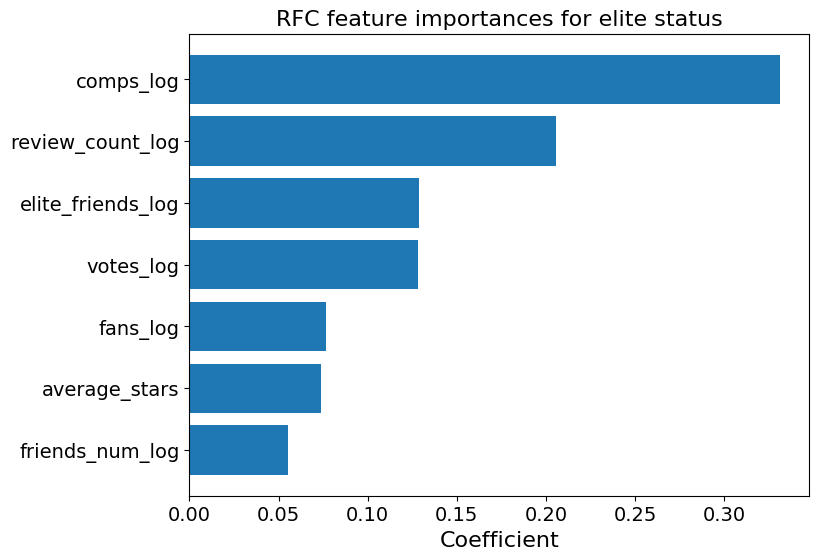

In [0]:
# plot

fig,ax = plt.subplots(figsize=(8,6))

ax.barh(range(len(chart_imps)), chart_imps, align = 'center')
ax.tick_params(direction='out', labelsize=14)
ax.set_xlabel('Coefficient', fontsize=16)
ax.set_title('RFC feature importances for elite status', fontsize=16)

plt.yticks(range(len(chart_imps)), chart_labels)
plt.rcParams.update(plt.rcParamsDefault)
plt.savefig('features_importance.png', format='png',bbox_inches='tight',dpi=600)
plt.show()

#plt.figure(figsize = (10, 8))
#plt.barh(range(len(chart_imps)), chart_imps, align = 'center')
#plt.yticks(range(len(chart_imps)), chart_labels)
#plt.title('Feature Importances - RFC')
#plt.show()

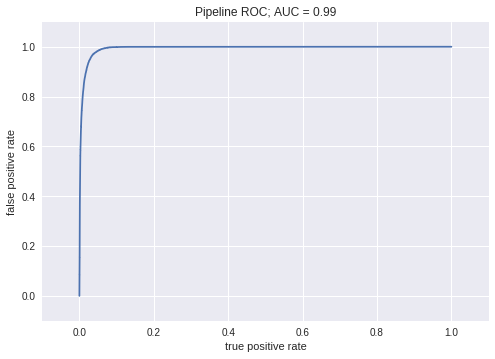

In [0]:
plot_roc(final_rf, Xtest, ytest)

# Scores

In [0]:
def prob_final_model(xtrain, xtest, ytrain, ytest, model):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include scaling in pipeline.
    Return model."""
    pipeline = make_pipeline(StandardScaler(), model)
    m = pipeline.fit(xtrain, ytrain)
    test_pred = m.predict_proba(xtest)
  
    return test_pred
  
  
final_score= prob_final_model(Xtrain, Xtest, ytrain, ytest, best_rf_final)

In [0]:
final_score[:,1]

In [0]:
users_arizona['scores']=final_score[:,1]

In [0]:
users_arizona

In [0]:
users_arizona.to_csv('Users_arizona_scores.csv')

## New user scores

In [0]:
def prob_final_model(xtrain, xtest, ytrain, ytest, model):
    """Get accuracy, precision, recall, and f1 scores for model. 
    Include scaling in pipeline.
    Return model."""
    pipeline = make_pipeline(StandardScaler(), model)
    m = pipeline.fit(xtrain, ytrain)
    test_pred = m.predict_proba(xtest)
  
    return test_pred
  
  
final_score2= prob_final_model(Xtrain, xtest_2, ytrain, ytest_2, best_rf_final)

final_score2[:,1]

In [0]:
final_rf = test_final_model(Xtrain, xtest_2, ytrain, ytest_2, best_rf_final)

In [0]:
users_id['scores']=final_score2[:,1]

In [0]:
users_id

In [0]:
users_id.to_csv('new_users_scores.csv')